In [1]:
import time
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LinearRegression,GammaRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import lightgbm as lgb

In [2]:
# 分析データに関する設定
SEED = 100 #これを基本的に使用
# SEED = 202120971 # #これを基本的に使用（自分の学籍番号）

## データ準備

In [3]:
# 1. データの読み込み
###### 633 nm ######
wavelen = 633

# 補正後のprofile特徴量
feature_First_df = pd.read_csv(f'./../data/data_FirstStorage/data_laser/feature/feature_CB_HDR/feature_shake/{wavelen}nm/feature_all.csv',index_col=0)
feature_Second_df = pd.read_csv(f'./../data/data_SecondStorage/data_laser/feature/feature_CB_HDR/feature_shake/{wavelen}nm/feature_all.csv',index_col=0)
feature_df_633 = pd.concat([feature_First_df,feature_Second_df],axis=0)
feature_df_633.columns = [f'{col}_{wavelen}' for col in feature_df_633.columns]


###### 850 nm ######
wavelen = 850

# 補正後のprofile特徴量
feature_First_df = pd.read_csv(f'./../data/data_FirstStorage/data_laser/feature/feature_CB_HDR/feature_shake/{wavelen}nm/feature_all.csv',index_col=0)
feature_Second_df = pd.read_csv(f'./../data/data_SecondStorage/data_laser/feature/feature_CB_HDR/feature_shake/{wavelen}nm/feature_all.csv',index_col=0)
feature_df_850 = pd.concat([feature_First_df,feature_Second_df],axis=0)
feature_df_850.columns = [f'{col}_{wavelen}' for col in feature_df_850.columns]

##### 説明変数 #####
feature_df = pd.concat([feature_df_633, feature_df_850],axis=1)

##### 目的変数 #####
target_First_df = pd.read_csv(f'./../data/data_FirstStorage/data_mealiness_shake/Mealiness.csv',index_col=0)
target_First_df = target_First_df.iloc[:feature_First_df.shape[0],0].astype(float) #初期状態が文字列だったので，小数に変換
target_Second_df = pd.read_csv(f'./../data/data_SecondStorage/data_mealiness_shake/Mealiness.csv',index_col=0)
target_Second_df = target_Second_df.iloc[:feature_Second_df.shape[0],0].astype(float) #初期状態が文字列だったので，小数に変換

target_df = pd.concat([target_First_df, target_Second_df],axis=0)
target_df.index = feature_df.index


# 実験に失敗したサンプル2(Firststorage, 04_03_2)を削除
# 実験に失敗したサンプル2(Secondstorage, 04_08_4)を削除
target_df = target_df.dropna(axis=0)
feature_df = feature_df.reset_index()
target_df = target_df.reset_index()

target_df = target_df.drop(target_df.index[84],axis=0)
feature_df = feature_df.drop([feature_df.index[84],feature_df.index[195]],axis=0)

feature_df = feature_df.drop(['index'],axis=1)
target_df.index = target_df['index']
target_df = target_df.drop(['index'],axis=1)
feature_df.index = target_df.index

## データの標準化

In [4]:
# データの分割
# 各貯蔵期間の09, 10サンプルをtestに用いる
X_test = feature_df[feature_df.index.str.contains('9|10')]
X_train = feature_df.drop(X_test.index, axis=0)
y_test = target_df[target_df.index.str.contains('9|10')]
y_train = target_df.drop(y_test.index, axis=0)

# 標準化
scaler = StandardScaler()

X_train_scale = scaler.fit_transform(X_train)
X_train_scale = pd.DataFrame(X_train_scale,
                             columns = X_train.columns,
                             index = X_train.index)


X_test_scale = scaler.transform(X_test)
X_test_scale = pd.DataFrame(X_test_scale,
                             columns = X_test.columns,
                             index = X_test.index)


# # 標準化（粉質化）
# scaler = StandardScaler()

# y_train_scale = scaler.fit_transform(y_train)
# y_train = pd.DataFrame(y_train_scale,
#                        columns = y_train.columns,
#                        index = y_train.index)


# y_test_scale = scaler.transform(y_test)
# y_test = pd.DataFrame(y_test_scale,
#                       columns = y_test.columns,
#                       index = y_test.index)


## 変数選択

In [5]:
# 相関の確認
# abs(pd.concat([feature_df,target_df],axis=1).corr())['Mealiness (%)'].sort_values(ascending=False).head(40)
# plt.scatter(feature_df['Farrell_1_633'],target_df)

In [6]:
# trainデータで、mealinessと相関係数が0.1以上の変数のみ抽出
THRESH = 0.1
temp = abs(pd.concat([X_train_scale,y_train],axis=1).corr())['Mealiness (%)'][abs(pd.concat([X_train_scale, y_train],axis=1).corr())['Mealiness (%)'].sort_values(ascending=False)>=THRESH].index
temp = temp.drop(['Mealiness (%)'])


X_train_scale = X_train_scale.loc[:,temp]
X_test_scale = X_test_scale.loc[:,temp]

print('特徴量の数',X_train_scale.shape[1],'個')

特徴量の数 187 個


In [7]:
# kf_inner = KFold(n_splits=10, shuffle=True, random_state=126881)
kf_inner = KFold(n_splits=10, shuffle=True, random_state=SEED)

In [8]:
%%time

##### パラメータの設定 #####
# PLS
param_pls = {'n_components':[i for i in range(1,10)]} # 7best

# SVM
param_svm = {
    # 'C':[i/10 for i in range(1000,3001)], 
    # 'gamma':[100,10,1,1e-1,1e-2,1e-3,1e-4,1e-5],
    # 'kernel':['rbf'],
    
    'kernel':['poly'],
    'degree':[1,2,3,4],
    
    # 'kernel':['linear']
}

param_ann = {'hidden_layer_sizes':[(90,),(60,),(30,)],# (88,),(44,)
             'activation':['relu'],
             'solver':['adam'],
             'alpha':[1e-2,1e-1,1,10,100,1000],#,
             'batch_size':[50,75,100,125,150],#
            }

##### GridSearch #####
# PLSのGridSearch 
CV_pls = GridSearchCV(
    PLSRegression(),
    param_pls,
    cv=kf_inner,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1
)
# SVMのGridSearch
CV_svm = GridSearchCV(
    SVR(),
    param_svm,
    cv=kf_inner,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
# ANNのGridSearch
CV_ann = GridSearchCV(
    MLPRegressor(early_stopping=True,random_state=SEED),
    param_ann,
    cv=kf_inner,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)


# GridSearchの結果表示
results_pls = CV_pls.fit(X_train_scale, y_train)
results_svm = CV_svm.fit(X_train_scale,y_train.values.ravel())
results_ann = CV_ann.fit(X_train_scale.values,y_train.values.ravel())

/Users/daiki/python_enviroment/MasterDegree/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/daiki/python_enviroment/MasterDegree/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/daiki/python_enviroment/MasterDegree/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/daiki/python_enviroment/MasterDegree/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to 

CPU times: user 3.07 s, sys: 1.14 s, total: 4.21 s
Wall time: 7.31 s


In [9]:
print('Best Parameter of PLS')
print(results_pls.best_params_)
print()
print('Best Parameter of SVM')
print(results_svm.best_params_)
print()
print('Best Parameter of ANN')
print(results_ann.best_params_)
print()


Best Parameter of PLS
{'n_components': 3}

Best Parameter of SVM
{'degree': 1, 'kernel': 'poly'}

Best Parameter of ANN
{'activation': 'relu', 'alpha': 100, 'batch_size': 75, 'hidden_layer_sizes': (90,), 'solver': 'adam'}



In [10]:
%%time

###### 指定したハイパラでモデル構築 #####

# PLS
pls = PLSRegression(n_components=results_pls.best_params_['n_components'])
model_PLS = pls.fit(X_train_scale,y_train)

# SVM
svm = SVR(
    # kernel='rbf',
    # C=results_svm.best_params_['C'], 
    # gamma=results_svm.best_params_['gamma'],
    kernel=results_svm.best_params_['kernel'],
    degree=results_svm.best_params_['degree'],
)
model_SVM = svm.fit(X_train_scale, y_train)

# ANN
ann = MLPRegressor(hidden_layer_sizes=results_ann.best_params_['hidden_layer_sizes'],
                   activation=results_ann.best_params_['activation'],
                   solver=results_ann.best_params_['solver'],
                   alpha=results_ann.best_params_['alpha'],
                   batch_size=results_ann.best_params_['batch_size'],
                   random_state=SEED
                  )

model_ANN = ann.fit(X_train_scale, y_train)



##### モデルの予測 #####

# trainの予測
y_pred_train_ANN = model_ANN.predict(X_train_scale).flatten()
y_pred_train_SVM = model_SVM.predict(X_train_scale).flatten()
y_pred_train_PLS = model_PLS.predict(X_train_scale).flatten()

y_pred_train_SVM_PLS = np.mean([y_pred_train_SVM,y_pred_train_PLS],axis=0)
y_pred_train_ANN_SVM = np.mean([y_pred_train_ANN,y_pred_train_SVM],axis=0)
y_pred_train_ANN_PLS = np.mean([y_pred_train_ANN,y_pred_train_PLS],axis=0)
y_pred_train_ANN_SVM_PLS = np.mean([y_pred_train_ANN,y_pred_train_SVM, y_pred_train_PLS],axis=0)


# testの予測
y_pred_SVM = model_SVM.predict(X_test_scale).flatten()
y_pred_PLS = model_PLS.predict(X_test_scale).flatten()
y_pred_ANN = model_ANN.predict(X_test_scale).flatten()

y_pred_SVM_PLS = np.mean([y_pred_SVM,y_pred_PLS.flatten()],axis=0)
y_pred_ANN_SVM = np.mean([y_pred_ANN,y_pred_SVM],axis=0)
y_pred_ANN_PLS = np.mean([y_pred_ANN,y_pred_PLS],axis=0)
y_pred_ANN_SVM_PLS = np.mean([y_pred_ANN,y_pred_SVM_PLS],axis=0)

# weight averaging
# weightを求める
model_list = [model_PLS,model_SVM,model_ANN]
i_weight_sum = 0
i_weight_list = []
for i_model in model_list:
    i_model_pred = i_model.predict(X_train_scale).flatten()
    i_weight = 1/np.sqrt(mean_squared_error(y_train.values.flatten(),i_model_pred.flatten())) # errorの逆数
    i_weight_list.append(i_weight)
    i_weight_sum += i_weight

i_weight_array = np.array(i_weight_list)/i_weight_sum

y_pred_train_weight_3 = np.average([y_pred_train_ANN,y_pred_train_SVM, y_pred_train_PLS],weights=i_weight_array,axis=0)
y_pred_weight_3 = np.average([y_pred_ANN,y_pred_SVM, y_pred_PLS],weights=i_weight_array,axis=0)

CPU times: user 2.63 s, sys: 28.6 ms, total: 2.66 s
Wall time: 307 ms


In [11]:
X_ensemble_test = pd.concat([
          pd.DataFrame(y_pred_PLS,columns=['PLS'],index=y_test.index),
          pd.DataFrame(y_pred_SVM,columns=['SVM'],index=y_test.index),
          pd.DataFrame(y_pred_ANN,columns=['ANN'],index=y_test.index),
          ],axis=1
         )
pd.concat([X_ensemble_test,y_test],axis=1).corr()

,PLS,SVM,ANN,Mealiness (%)
PLS,1.000000,0.898451,0.944466,0.624282
SVM,0.898451,1.000000,0.899287,0.660748
ANN,0.944466,0.899287,1.000000,0.684393
Mealiness (%),0.624282,0.660748,0.684393,1.000000


In [12]:
%%time
##### Stacking #####

X_ensemble_train = pd.concat([
          pd.DataFrame(y_pred_train_PLS,columns=['PLS'],index=y_train.index),
          pd.DataFrame(y_pred_train_SVM,columns=['SVM'],index=y_train.index),
          pd.DataFrame(y_pred_train_ANN,columns=['ANN'],index=y_train.index),
          ],axis=1
         )

X_ensemble_test = pd.concat([
          pd.DataFrame(y_pred_PLS,columns=['PLS'],index=y_test.index),
          pd.DataFrame(y_pred_SVM,columns=['SVM'],index=y_test.index),
          pd.DataFrame(y_pred_ANN,columns=['ANN'],index=y_test.index),
          ],axis=1
         )

# # stacking (regression model : ANN)
# param_ann = {'hidden_layer_sizes':[2*i for i in range(1,25)],
#              'activation':['relu'],
#              'solver':['adam'],
#              'alpha':[200,100,50,10,1,1e-1,1e-2],
#              'batch_size':[50,100,150],
#             }

# # Stacking(ANNのGridSearch)
# CV_ann_stacking = GridSearchCV(
#     MLPRegressor(random_state=SEED),
#     param_ann,
#     cv=kf_inner,
#     n_jobs=-1
# )

# results_ann_stack = CV_ann_stacking.fit(X_ensemble_train.values,y_train.values.ravel())
# ann = MLPRegressor(hidden_layer_sizes=results_ann_stack.best_params_['hidden_layer_sizes'],
#                    activation=results_ann_stack.best_params_['activation'],
#                    solver=results_ann_stack.best_params_['solver'],
#                    alpha=results_ann_stack.best_params_['alpha'],
#                    batch_size=results_ann_stack.best_params_['batch_size'],
#                    random_state=SEED
#                   )

# model_ANN = ann.fit(X_ensemble_train.values, y_train.values.ravel())

# y_pred_train_stack = model_ANN.predict(X_ensemble_train)
# y_pred_stack = model_ANN.predict(X_ensemble_test)

# # 最適化の表示
# print('Best Parameter of ANN')
# print(results_ann_stack.best_params_)
# print()

# stacking (regression model : SVM)
param_svm = {
    'kernel':['linear'],
    # 'C':[i/10 for i in range(300,1000)], 
    # 'degree':[1],
    # 'gamma':[200,100,10,1,1e-1,1e-2,1e-3,1e-4,1e-5]
    # 200,150,100,50,10,5,1,
}

# Stacking(SVMのGridSearch)
CV_svm_stacking = GridSearchCV(
    SVR(),
    param_svm,
    cv=kf_inner,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

results_svm_stack = CV_svm_stacking.fit(X_ensemble_train.values,y_train.values.ravel())
svm = SVR(
    kernel=results_svm_stack.best_params_['kernel'],
    # C=results_svm_stack.best_params_['C'],
    # gamma=results_svm_stack.best_params_['gamma'],
    # degree=results_svm_stack.best_params_['degree'],
    )

model_SVM = svm.fit(X_ensemble_train.values, y_train.values.ravel())

y_pred_train_stack = model_SVM.predict(X_ensemble_train)
y_pred_stack = model_SVM.predict(X_ensemble_test)

# 最適化の表示
print('Best Parameter of Ensemble SVM')
print(results_svm_stack.best_params_)
print()

Best Parameter of Ensemble SVM
{'kernel': 'linear'}

CPU times: user 68.3 ms, sys: 349 ms, total: 417 ms
Wall time: 53.7 ms


In [13]:
##### 精度評価 #####
temp = pd.DataFrame([
    [
        np.corrcoef(y_train.values.flatten(),y_pred_train_SVM)[0][1], 
        np.corrcoef(y_train.values.flatten(),y_pred_train_PLS.flatten())[0][1],
        np.corrcoef(y_train.values.flatten(),y_pred_train_ANN.flatten())[0][1],
        np.corrcoef(y_train.values.flatten(),y_pred_train_ANN_SVM_PLS.flatten())[0][1],
        np.corrcoef(y_train.values.flatten(),y_pred_train_stack.flatten())[0][1],
        np.corrcoef(y_train.values.flatten(),y_pred_train_weight_3.flatten())[0][1],
        
    ],
    
    [
        np.corrcoef(y_test.values.flatten(),y_pred_SVM)[0][1],
        np.corrcoef(y_test.values.flatten(),y_pred_PLS.flatten())[0][1],
        np.corrcoef(y_test.values.flatten(),y_pred_ANN.flatten())[0][1],
        np.corrcoef(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten())[0][1],
        np.corrcoef(y_test.values.flatten(),y_pred_stack.flatten())[0][1],
        np.corrcoef(y_test.values.flatten(),y_pred_weight_3.flatten())[0][1],
    ],
    
    [
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_SVM)),
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_PLS.flatten())),
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_ANN.flatten())),
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_ANN_SVM_PLS.flatten())),
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_stack.flatten())),
        np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_weight_3.flatten())),
    ],
    
    [
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_SVM)),
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_PLS.flatten())),
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN.flatten())),
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten())),
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_stack.flatten())),
        np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_weight_3.flatten())),
    ]
])

temp.columns = ['SVM','PLS','ANN','ANN+SVM+PLS','Stacking','Weighted averaging']
temp.index = ['R_train','R_test','RMSE_train','RMSE_test']

temp = temp.T.sort_values(by='RMSE_test',ascending=True)

SD = y_test.std().values[0]
SEP = np.sqrt((((y_test.values.flatten() - y_pred_stack)**2).sum())/(len(y_test)-1))
RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_stack.flatten()))
RANGE = (y_test.max() - y_test.min()).values[0]

# print(f'RPD[Stack]: {(SD/SEP):.2f}')
print(f'RPD: {(SD/RMSE):.2f}') # 
print(f'RER: {(RANGE/RMSE):.2f}')
print(f'EI: {100*(2*RMSE/RANGE):.2f}')

# 
temp

# RMSE_test: 7.37（投稿論文）
# RMSE_test: 7.39（HDR，

RPD: 1.36
RER: 5.59
EI: 35.81


,R_train,R_test,RMSE_train,RMSE_test
Stacking,0.722232,0.679593,6.317204,7.290963
ANN,0.714440,0.684393,6.687376,7.387610
ANN+SVM+PLS,0.678606,0.679001,6.980484,7.570550
Weighted averaging,0.680422,0.672048,6.937190,7.628707
PLS,0.656262,0.624282,6.858266,7.696192
SVM,0.571647,0.660748,8.038439,8.507267


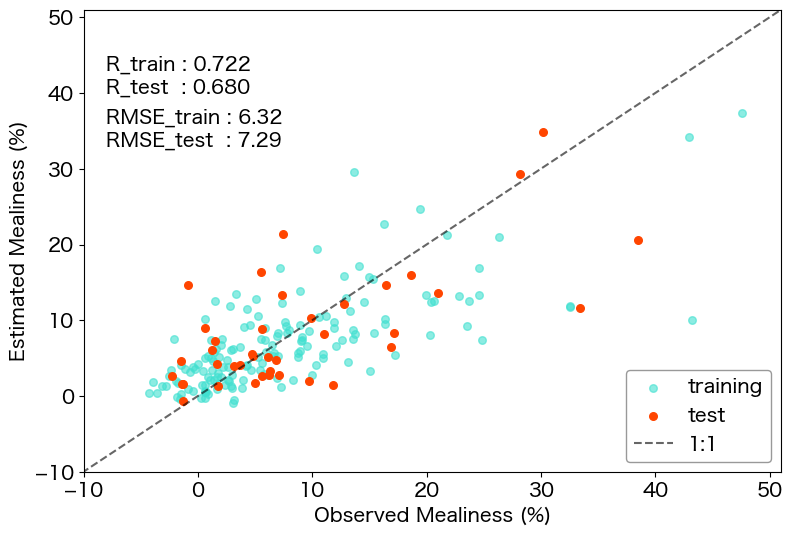

In [14]:
fig = plt.figure(figsize=(9,6))
plt.scatter(y_train,y_pred_train_stack,c='turquoise',alpha=0.6,label='training',marker='.',s=120)
plt.scatter(y_test,y_pred_stack,c='orangered',alpha=1,label='test',marker='.',s=120)
plt.plot([-100,100],[-100,100],c='k',linestyle='dashed',label='1:1',alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Observed Mealiness (%)',fontsize=14)
plt.ylabel('Estimated Mealiness (%)',fontsize=14)
plt.xlim(int(target_df.min())-6,int(target_df.max())+4)
plt.ylim(int(target_df.min())-6,int(target_df.max())+4)

MODEL = 'Stacking'
plt.text(-8,43,f"R_train : {temp.T[MODEL][0]:.3f}",fontsize=14)
plt.text(-8,40,f"R_test  : {temp.T[MODEL][1]:.3f}",fontsize=14)
plt.text(-8,36,f"RMSE_train : {temp.T[MODEL][2]:.2f}",fontsize=14)
plt.text(-8,33,f"RMSE_test  : {temp.T[MODEL][3]:.2f}",fontsize=14)

plt.legend(loc='lower right', fontsize=14, edgecolor='gray')
plt.show()

# fig.savefig(f'./../../something/yyplot_2wave_{MODEL}.png',dpi=360)
# fig.savefig('./../../something/ForPaper/Fig7.png',dpi=400)
# fig.savefig('./../../something/ForPaper/Fig7.eps',dpi=400)

In [15]:
(y_train.std().values[0])/temp.iloc[:,2]

Stacking              1.443410
ANN                   1.363512
ANN+SVM+PLS           1.306259
Weighted averaging    1.314411
PLS                   1.329537
SVM                   1.134339
Name: RMSE_train, dtype: float64

In [150]:
(y_test.std().values[0])/temp.iloc[:,3]

ANN                   1.177116
ANN+SVM               1.167145
SVM                   1.153178
Stacking              1.145306
ANN+SVM+PLS           1.142802
Weighted averaging    1.120606
SVM+PLS               1.040521
ANN+PLS               1.035467
PLS                   0.781648
Name: RMSE_test, dtype: float64

In [16]:
pd.DataFrame(((y_train.max() - y_train.min()).values[0])/temp.iloc[:,2])

,RMSE_train
Stacking,8.212780
ANN,7.758171
ANN+SVM+PLS,7.432408
Weighted averaging,7.478793
PLS,7.564858
SVM,6.454214


In [17]:
pd.DataFrame(((y_test.max() - y_test.min()).values[0])/temp.iloc[:,3])

,RMSE_test
Stacking,5.585801
ANN,5.512726
ANN+SVM+PLS,5.379512
Weighted averaging,5.338502
PLS,5.291690
SVM,4.787186


In [18]:
200*temp.iloc[:,2]/(y_train.max() - y_train.min()).values[0]

Stacking              24.352290
ANN                   25.779271
ANN+SVM+PLS           26.909180
Weighted averaging    26.742284
PLS                   26.438037
SVM                   30.987508
Name: RMSE_train, dtype: float64

In [19]:
200*temp.iloc[:,3]/(y_test.max() - y_test.min()).values[0]

Stacking              35.805072
ANN                   36.279694
ANN+SVM+PLS           37.178090
Weighted averaging    37.463695
PLS                   37.795107
SVM                   41.778201
Name: RMSE_test, dtype: float64

In [20]:
SD = y_test.std().values[0]
SEP = np.sqrt((((y_test.values.flatten() - y_pred_stack)**2).sum())/(len(y_test)-1))
RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_stack.flatten()))
RANGE = (y_test.max() - y_test.min()).values[0]

# print(f'RPD[Stack]: {(SD/SEP):.2f}')
print(f'RPD: {(SD/RMSE):.2f}') # 
print(f'RER: {(RANGE/RMSE):.2f}')
print(f'EI: {100*(2*SEP/RANGE):.2f}')

RPD: 1.36
RER: 5.59
EI: 36.26


In [21]:
pd.concat([X_ensemble_train,y_train],axis=1).corr()

,PLS,SVM,ANN,Mealiness (%)
PLS,1.000000,0.871187,0.941468,0.656262
SVM,0.871187,1.000000,0.890466,0.571647
ANN,0.941468,0.890466,1.000000,0.714440
Mealiness (%),0.656262,0.571647,0.714440,1.000000


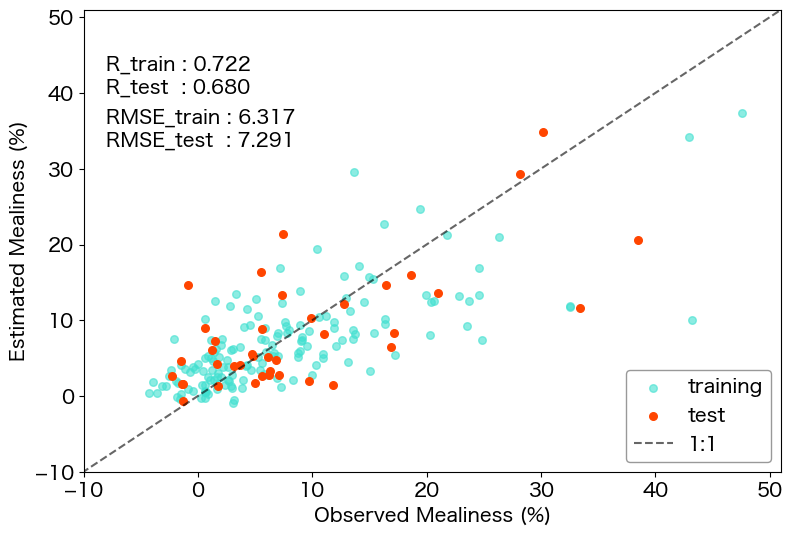

In [23]:
fig = plt.figure(figsize=(9,6))
plt.scatter(y_train,y_pred_train_stack,c='turquoise',alpha=0.6,label='training',marker='.',s=120)
plt.scatter(y_test,y_pred_stack,c='orangered',alpha=1,label='test',marker='.',s=120)
plt.plot([-100,100],[-100,100],c='k',linestyle='dashed',label='1:1',alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Observed Mealiness (%)',fontsize=14)
plt.ylabel('Estimated Mealiness (%)',fontsize=14)
plt.xlim(int(target_df.min())-6,int(target_df.max())+4)
plt.ylim(int(target_df.min())-6,int(target_df.max())+4)

MODEL = 'Stacking'
plt.text(-8,43,f"R_train : {temp.T[MODEL][0]:.3f}",fontsize=14)
plt.text(-8,40,f"R_test  : {temp.T[MODEL][1]:.3f}",fontsize=14)
plt.text(-8,36,f"RMSE_train : {temp.T[MODEL][2]:.3f}",fontsize=14)
plt.text(-8,33,f"RMSE_test  : {temp.T[MODEL][3]:.3f}",fontsize=14)

plt.legend(loc='lower right', fontsize=14, edgecolor='gray')
plt.show()

# fig.savefig(f'./../../something/yyplot_2wave_{MODEL}.png',dpi=360)
# fig.savefig('./../output/something/ForPaper/Fig7.png',dpi=400)
# fig.savefig('./../../something/ForPaper/Fig7.eps',dpi=400)

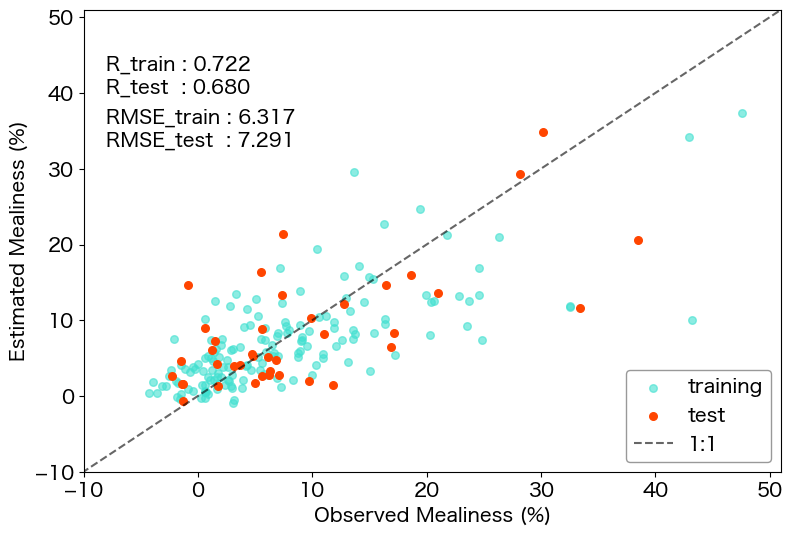

In [24]:


fig = plt.figure(figsize=(9,6))
plt.scatter(y_train,y_pred_train_stack,c='turquoise',alpha=0.6,label='training',marker='.',s=120)
plt.scatter(y_test,y_pred_stack,c='orangered',alpha=1,label='test',marker='.',s=120)
plt.plot([-100,100],[-100,100],c='k',linestyle='dashed',label='1:1',alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Observed Mealiness (%)',fontsize=14)
plt.ylabel('Estimated Mealiness (%)',fontsize=14)
plt.xlim(int(target_df.min())-6,int(target_df.max())+4)
plt.ylim(int(target_df.min())-6,int(target_df.max())+4)

MODEL = 'Stacking'
plt.text(-8,43,f"R_train : {temp.T[MODEL][0]:.3f}",fontsize=14)
plt.text(-8,40,f"R_test  : {temp.T[MODEL][1]:.3f}",fontsize=14)
plt.text(-8,36,f"RMSE_train : {temp.T[MODEL][2]:.3f}",fontsize=14)
plt.text(-8,33,f"RMSE_test  : {temp.T[MODEL][3]:.3f}",fontsize=14)

plt.legend(loc='lower right', fontsize=14, edgecolor='gray')
plt.show()

# fig.savefig(f'./../../something/yyplot_2wave_{MODEL}.png',dpi=360)
# fig.savefig('./../../something/ForPaper/Fig6.png',dpi=400)

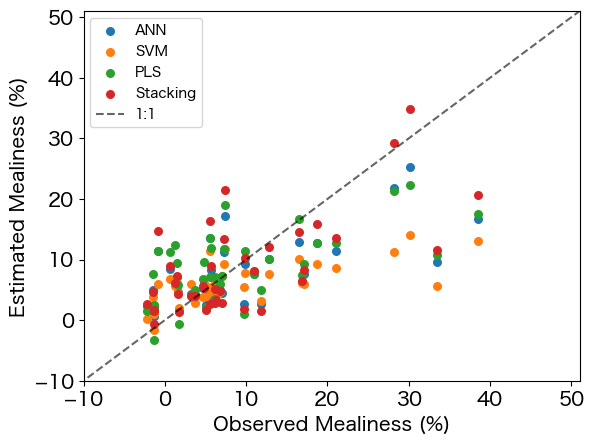

In [25]:
plt.scatter(y_test,y_pred_ANN,alpha=1,label='ANN',marker='.',s=120)
plt.scatter(y_test,y_pred_SVM,alpha=1,label='SVM',marker='.',s=120)
plt.scatter(y_test,y_pred_PLS,alpha=1,label='PLS',marker='.',s=120)
# plt.scatter(y_test,y_pred_ANN_SVM_PLS,alpha=1,label='ANN+SVM+PLS',marker='.',s=120)
plt.scatter(y_test,y_pred_stack,alpha=1,label='Stacking',marker='.',s=120)

plt.plot([-100,100],[-100,100],c='k',linestyle='dashed',label='1:1',alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Observed Mealiness (%)',fontsize=14)
plt.ylabel('Estimated Mealiness (%)',fontsize=14)
plt.xlim(int(target_df.min())-6,int(target_df.max())+4)
plt.ylim(int(target_df.min())-6,int(target_df.max())+4)
plt.legend()